In [1]:
from jax import grad
import jax.numpy as jnp
from IPython.core.display import HTML
#this css file can be downloaded from [David's repo](https://github.com/ketch/PseudoSpectralPython/blob/master/custom.css)
#Then set the address of css file as per your address of file
#Following two commands are not needed for calculations.
css_file = '/Users/rajvanmp/Downloads/custom.css'

#HTML(open(css_file, "r").read())

In [2]:
from scipy import integrate
import sympy as sp
import numpy as np
import sys
from numpy import linalg as la 
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation
matplotlib.rcParams['animation.embed_limit'] = 2**128


HTML(open(css_file, "r").read())
font = {'size'   : 15}
matplotlib.rc('font', **font)
#from RKSchemes import ImEx_schemes

fft = np.fft.fft
ifft = np.fft.ifft

from IPython.display import HTML
css_file = '/Users/rajvanmp/Downloads/custom.css'

In [3]:
xxx = np.arange(1.0,10.0,1.0)
xxx = xxx+1j*xxx
xl = [i for i in xxx]
axl = np.abs(xl)
print(axl,type(axl))

[ 1.41421356  2.82842712  4.24264069  5.65685425  7.07106781  8.48528137
  9.89949494 11.3137085  12.72792206] <class 'numpy.ndarray'>


In [4]:




font = {'size'   : 15}
matplotlib.rc('font', **font)

fft = np.fft.fft
ifft = np.fft.ifft


In [5]:
kppa = 8.0
a= kppa*kppa/16.0
c = 0.5
xo = -2.5
import jax

def exact_soln_np(t,x):
    bta=-kppa
    omg = np.sqrt(a)*((x-xo)-c*t)
    #print("omg shape",omg.shape)
    f = (2.0*a/bta)/np.cosh(omg)
    thta = 0.5*c*(x-xo) - (0.25*c*c -a)*t
    
    sol = f*np.cos(thta)+1j*f*np.sin(thta)
    
    return(sol)

def exact_soln_real(t,x,a=a,c=c,xo=xo,kppa=kppa):
    bta = - kppa
    omg = np.sqrt(a)*((x-xo)-c*t)
    #print("omg shape",omg.shape)
    f = (2.0*a/bta)/jnp.cosh(omg)
    thta = 0.5*c*(x-xo) - (0.25*c*c -a)*t
    
    sol = f*jnp.cos(thta)
    
    return(sol)
def exact_soln_imag(t,x,a=a,c=c,xo=xo,kppa=kppa):
    bta = - kppa
    omg = np.sqrt(a)*((x-xo)-c*t)
    #print("omg shape",omg.shape)
    f = (2.0*a/bta)/jnp.cosh(omg)
    thta = 0.5*c*(x-xo) - (0.25*c*c -a)*t
    
    sol = f*jnp.sin(thta)
    
    return(sol)

#sol = jax.vmap(exact_soln)

<class 'numpy.ndarray'> complex64


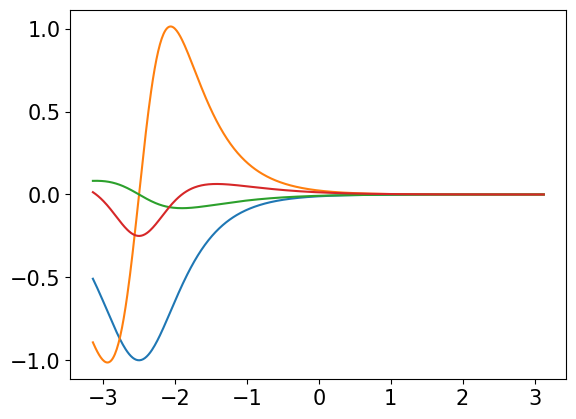

In [6]:

i=0
L = 2*np.pi; m = 512
x = np.arange(-m/2,m/2)*(L/m)
xj = jnp.array(x)
gsol_real =  grad(exact_soln_real,1)
gsol_imag =  grad(exact_soln_imag,1)
gsol_real =  jax.vmap(grad(exact_soln_real,1))
gsol_imag =  jax.vmap(grad(exact_soln_imag,1))

dx_sol_real=gsol_real(np.zeros_like(x),xj)
dx_sol_imag=gsol_imag(np.zeros_like(x),xj)
dx_sol = np.array(dx_sol_real)+1j*np.array(dx_sol_imag)

sol_real = exact_soln_real(0.0,xj)
sol_imag = exact_soln_imag(0.0,xj)
sol = np.array(sol_real)+1j*np.array(sol_imag)
print(type(sol),sol.dtype)
plt.plot(xj,np.real(sol))
plt.plot(xj,np.real(dx_sol))
plt.plot(xj,np.imag(sol))
plt.plot(xj,np.imag(dx_sol))
#plt.plot(xj,dx_sol)
#plt.plot(xj,np.zeros_like(xj),"k-")

In [7]:
print(type(sol),type(dx_sol))

<class 'numpy.ndarray'> <class 'numpy.ndarray'>


512


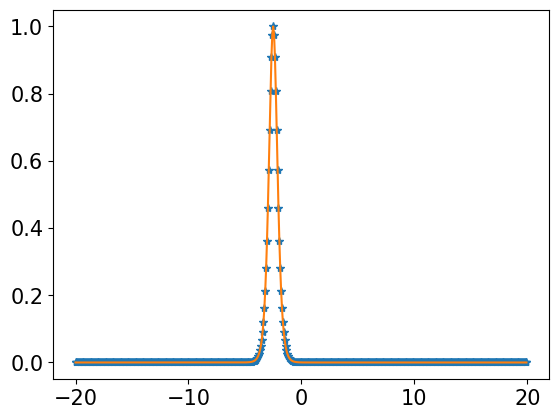

In [39]:
L = 2*20.0; m = 512
x = np.arange(-m/2,m/2)*(L/m)
xi = np.fft.fftfreq(m)*m*2*np.pi/L

dx_sol_real=gsol_real(np.zeros_like(x),x)
dx_sol_imag=gsol_imag(np.zeros_like(x),x)
dx_sol = np.array(dx_sol_real)+1j*np.array(dx_sol_imag)

sol_real = exact_soln_real(0.0,x)
sol_imag = exact_soln_imag(0.0,x)
sol = np.array(sol_real)+1j*np.array(sol_imag)

amp = np.square(sol_real)+np.square(sol_imag)
npsol = np.square(np.abs(exact_soln_np(np.zeros_like(x),x)))







#u0 = np.zeros(2*m)

q0_ini  = sol
q1_ini  = dx_sol
vh = np.real(q0_ini)
wh = np.imag(q0_ini)

ph = np.real(q0_ini)
qh = np.imag(q0_ini)

u_ini = np.stack((q0_ini,q1_ini),axis=1)
tau = 0.01



plt.plot(x,np.square(np.abs(u_ini[:,0])),"*")
plt.plot(x,npsol)
print(len(xi))

In [40]:
ft = np.zeros_like(u_ini)+1j*np.zeros_like(u_ini)
ft[:,0]=np.fft.fft(u_ini[:,0])
ft[:,1]=np.fft.fft(u_ini[:,1])
bbb = np.squeeze(np.matmul(lmdamat,np.expand_dims(ft,axis=-1)))
bbb.shape

(512, 2)

In [41]:
def rhs_linear(uft,u,xi,tau,kppa):
    #Evaluate the linear term
    m = len(xi)
    #rho = u[:m]; q = u[m:];
    q0 = u[:,0]
    q1 = u[:,1]
    v = np.zeros_like(u)
    q0hat = uft[:,0]
    q1hat = uft[:,1]
    q0_x = ifft(1j*xi*q0hat)
   #q0_xx = ifft(-xi*xi*q0hat)
    q1_x = ifft(1j*xi*q1hat)
    rhs_q0 = 1j*q1_x
    rhs_q1 = 1j*(-q0_x+q1)/tau
    v[:,0] = rhs_q0; v[:,1] = rhs_q1
    return v

In [42]:
def rhs_nonlinear(u,uft, xi,tau,kppa):
    #Evaluate the nonlinear term
    m = len(xi)
    q0 = u[:,0]; q1 = u[:,1]
    v = np.zeros_like(u)
    q0_rhs = 1j*kppa*np.square(np.abs(q0))*q0
    q1_rhs = np.zeros_like(q0_rhs)
    
    v[:,0] = q0_rhs; v[:,1] = q1_rhs
    return v

In [43]:
sys.path.append('/Users/rajvanmp/station_X/pyGP_fields')

In [44]:
from GPE import GPE_scalar_field
from GPE import ImEx
from GPE import GPE_scalar_field_1d2c

In [45]:
A    = np.array([[0,0,0],[5/6.,0,0],[11/24,11/24,0]])
Ahat = np.array([[2./11,0,0],[205/462.,2./11,0],[2033/4620,21/110,2/11]])
b = np.array([24/55.,1./5,4./11])
bhat = b

imx = ImEx(3,Ahat,A,bhat,b)
lmda_list=[]
dt=0.001
for s in range(imx.s):
    impf = imx.im_A[s][s]
    print(s,imx.s)
    omega = xi*dt*impf
    bta = -xi*dt*impf/tau
    chk = np.ones_like(xi)
    
    l = [[[chk[i],omega[i]],[bta[i],(chk[i]-1j*dt*impf/tau)]] for i in range(len(xi))]
    #l = [[[1.0+impf*dt*1j*np.square(xi[i]),0.0 ],[bta[i],(chk[i]-1j*dt)/tau]] for i in range(len(xi))]

    mt = np.array(l)
    lmdamat = np.linalg.inv(mt)

    lmda_list.append(lmdamat)


#ldecp = [[[chk[i],-omega[i]],[-bta[i],chk[i]*1j/tau]] for i in range(len(xi))]
#f = np.array([[rho0[i],q0[i]] for i in range(len(x))])
#dtl = -bta+omega
    
#lmdamat = [[-(bta/dtl), omega/dtl],[-(1.0/dtl), 1.0/dtl]]

print(mt.shape, mt.dtype,lmdamat.shape,q0_ini.shape,q1_ini.shape,u_ini.shape)

0 3
1 3
2 3
(512, 2, 2) complex128 (512, 2, 2) (512,) (512,) (512, 2)


In [46]:
def run_HE_example(dt):
    
    T = 5.0 
    tmax = T

    

    num_plots = 50
    nplt = np.floor((tmax/num_plots)/dt)
    nmax = int(round(tmax/dt))
    #print(nplt,"nmax",nmax)
    
   
    mass_ini = np.sum(np.square(np.abs(q0_ini)))

    frames = [u_ini,]
   
    tt = [0,]
    err_l = []
    mass_l = []
    mass_err_l=[]
    
    rhoq = GPE_scalar_field_1d2c(m,2,rhs_linear,rhs_nonlinear,imx,u_ini)
    
    
    for n in range(0,nmax):
        
        #print(n)
        for k in range(imx.s):
            rhoq.update_stage_sum(k,dt)
            
            rhoq.do_fft(k,lmda_list[k],dt)
            
            rhoq.update_K(k,xi,tau,kppa)
           
            
            
            
        rhoq.sum_contributions(dt)
        
        
        
        t = (n+1)*dt
        

        
        
        if np.mod(n,nplt) == 0:
            frames.append(rhoq.psi)
            
            tt.append(t)
            
            #err = sol_err(psi.psi,t,nx,T,max_err)
           # err_l.append(err)
            
           # mass = psi_1.calc_mass()+psi_2.calc_mass()
           # mass_err = (mass-mass_ini)/mass_ini
            
          ##  mass_l.append(mass)
           # mass_err_l.append(mass_err)
            
            print("time ",t/tmax,t)
            


    #err =  sol_err(psi.psi,t,nx,T,max_err)
    #err_l.append(err)
            
   # mass = psi_1.calc_mass()+psi_2.calc_mass()
    #mass_err = (mass-mass_ini)/mass_ini
            
   # mass_l.append(mass)
   # mass_err_l.append(mass_err)
       
    return frames,tt
    

In [47]:
f,tt = run_HE_example(dt)
f[0].shape

class shapes (512, 2) (3, 512, 2)
my shape (512, 2) psi shape (512, 2)
time  0.0002 0.001
time  0.020200000000000003 0.101
time  0.0402 0.201
time  0.0602 0.301
time  0.08020000000000001 0.401
time  0.1002 0.501
time  0.1202 0.601
time  0.14020000000000002 0.7010000000000001
time  0.1602 0.801
time  0.1802 0.901
time  0.20020000000000002 1.0010000000000001
time  0.2202 1.101
time  0.24020000000000002 1.201
time  0.2602 1.301
time  0.2802 1.401
time  0.3002 1.5010000000000001
time  0.3202 1.601
time  0.3402 1.701
time  0.36019999999999996 1.801
time  0.3802 1.901
time  0.4002 2.001
time  0.4202 2.101
time  0.44020000000000004 2.201
time  0.46020000000000005 2.301
time  0.48020000000000007 2.4010000000000002
time  0.5002 2.501
time  0.5202 2.601
time  0.5402 2.701
time  0.5602 2.801
time  0.5802 2.9010000000000002
time  0.6002 3.001
time  0.6202 3.101
time  0.6402 3.201
time  0.6602 3.301
time  0.6802 3.4010000000000002
time  0.7001999999999999 3.501
time  0.7202 3.601
time  0.7402 3.701

(512, 2)

In [36]:
f0 = [np.real(fe[:,0]) for fe in f]
f1 = [np.real(fe[:,1]) for fe in f]
#print(f0[-1].shape,f1[-1].shape)

In [48]:

def plot_solution(frames, x, tt, xi,exct_fnc,plot_type="real",plot_type2="none"):
   
    frames_sol = [exct_fnc(t*np.ones_like(x),x) for t in tt]
    if plot_type=="real":
        frames = np.real(frames)
        frames_sol=np.real(frames_sol)
    elif plot_type=="imag":
        frames=np.imag(frames)
        frames_sol = np.imag(frames_sol)
    else:
        frames=np.square(np.abs(frames))
        frames_sol = np.square(np.abs(frames_sol))
    fig = plt.figure(figsize=(12,8))
    axes = fig.add_subplot(211)
    axes2 = fig.add_subplot(212)
    if plot_type2=="diff":
        line, = axes.plot(x,frames[0][:,0]-frames_sol[0][:],lw=3)
    else:
        line, = axes.plot(x,frames[0][:,0],lw=3)
        linesol,= axes.plot(x,frames_sol[0][:],"--",lw=3)
    line2, = axes2.plot(x,frames[0][:,1],lw=3)

    
    
    #axes2.semilogy([xi_max/2.,xi_max/2.],[1.e-6,4e8],'--r')
    #axes2.semilogy([-xi_max/2.,-xi_max/2.],[1.e-8,4e10],'--r')
    if plot_type2=="diff":
        axes.set_ylabel(r'$q0-u$',fontsize=30)
    else:
        axes.set_ylabel(r'$q0$',fontsize=30)
    axes2.set_ylabel(r'$q1$',fontsize=30)
    plt.tight_layout()
    plt.close()

    def plot_frame(i):
        if plot_type2=="diff":
            line.set_data(x,frames[i][:,0]-frames_sol[i][:])
        #
        #power_spectrum = np.abs(uuhat[i])**2
        else:
            line.set_data(x,frames[i][:,0])
            linesol.set_data(x,frames_sol[i][:])
        line2.set_data(x,frames[i][:,1])
        axes.set_title('t= %.2e' % tt[i])
        axes.set_xlim((-20.0,20.0))
        axes.set_ylim((-1.0,1.0))
        axes2.set_xlim((-20.0,20.0))
        axes2.set_ylim((-1,10))

    anim = matplotlib.animation.FuncAnimation(fig, plot_frame,
                                              frames=len(frames), interval=100,
                                              repeat=False)
    return HTML(anim.to_jshtml())

In [49]:
plot_solution(f,  x, tt, xi,exct_fnc=exact_soln_np,plot_type="ss")

/Users/Shared/my_installs/anaconda3/envs/k@ust/lib/python3.10/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/Shared/my_installs/anaconda3/envs/k@ust/lib/python3.10/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


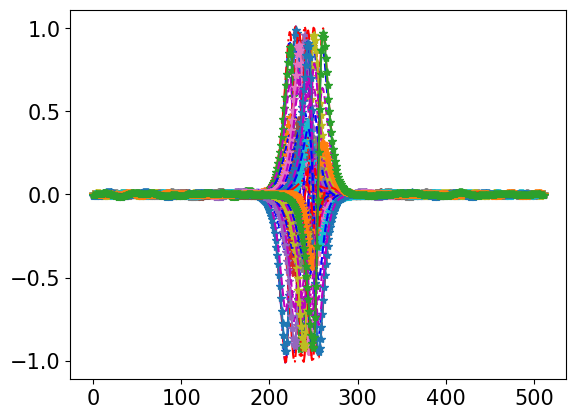

In [19]:
mrk = ("b--","r-.","-*","m--")
for i in range(len(f)):
    ax = plt.subplot()
    j=i%4
    ax.plot(f[i][:,1],mrk[j],label=str(i))

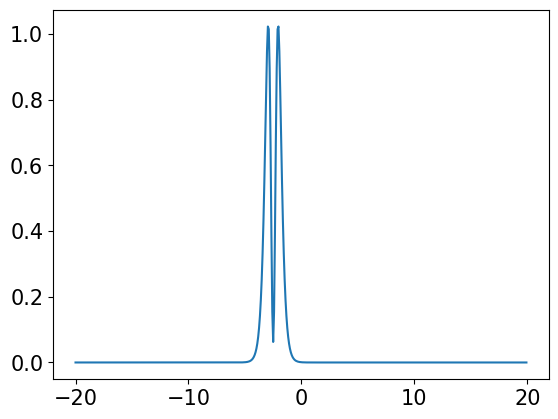

In [20]:
i=0
amp0 = np.square(np.abs(f[i][:,0]))
amp1 = np.square(np.abs(f[i][:,1]))
plt.plot(x,amp1)